Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 100] Loss: 4.570
[Epoch 1, Batch 200] Loss: 4.297
[Epoch 1, Batch 300] Loss: 4.196
[Epoch 1, Batch 400] Loss: 4.131
[Epoch 1, Batch 500] Loss: 4.104
[Epoch 1, Batch 600] Loss: 4.063
[Epoch 1, Batch 700] Loss: 3.983
[Epoch 2, Batch 100] Loss: 3.927
[Epoch 2, Batch 200] Loss: 3.882
[Epoch 2, Batch 300] Loss: 3.863
[Epoch 2, Batch 400] Loss: 3.861
[Epoch 2, Batch 500] Loss: 3.794
[Epoch 2, Batch 600] Loss: 3.781
[Epoch 2, Batch 700] Loss: 3.713
[Epoch 3, Batch 100] Loss: 3.635
[Epoch 3, Batch 200] Loss: 3.634
[Epoch 3, Batch 300] Loss: 3.607
[Epoch 3, Batch 400] Loss: 3.529
[Epoch 3, Batch 500] Loss: 3.510
[Epoch 3, Batch 600] Loss: 3.485
[Epoch 3, Batch 700] Loss: 3.481
[Epoch 4, Batch 100] Loss: 3.384
[Epoch 4, Batch 200] Loss: 3.417
[Epoch 4, Batch 300] Loss: 3.379
[Epoch 4, Batch 400] Loss: 3.345
[Epoch 4, Batch 500] Loss: 3.335
[Epoch 4, Batch 600] Loss: 3.306
[Epoch 4, Batch 700] Loss: 3.261


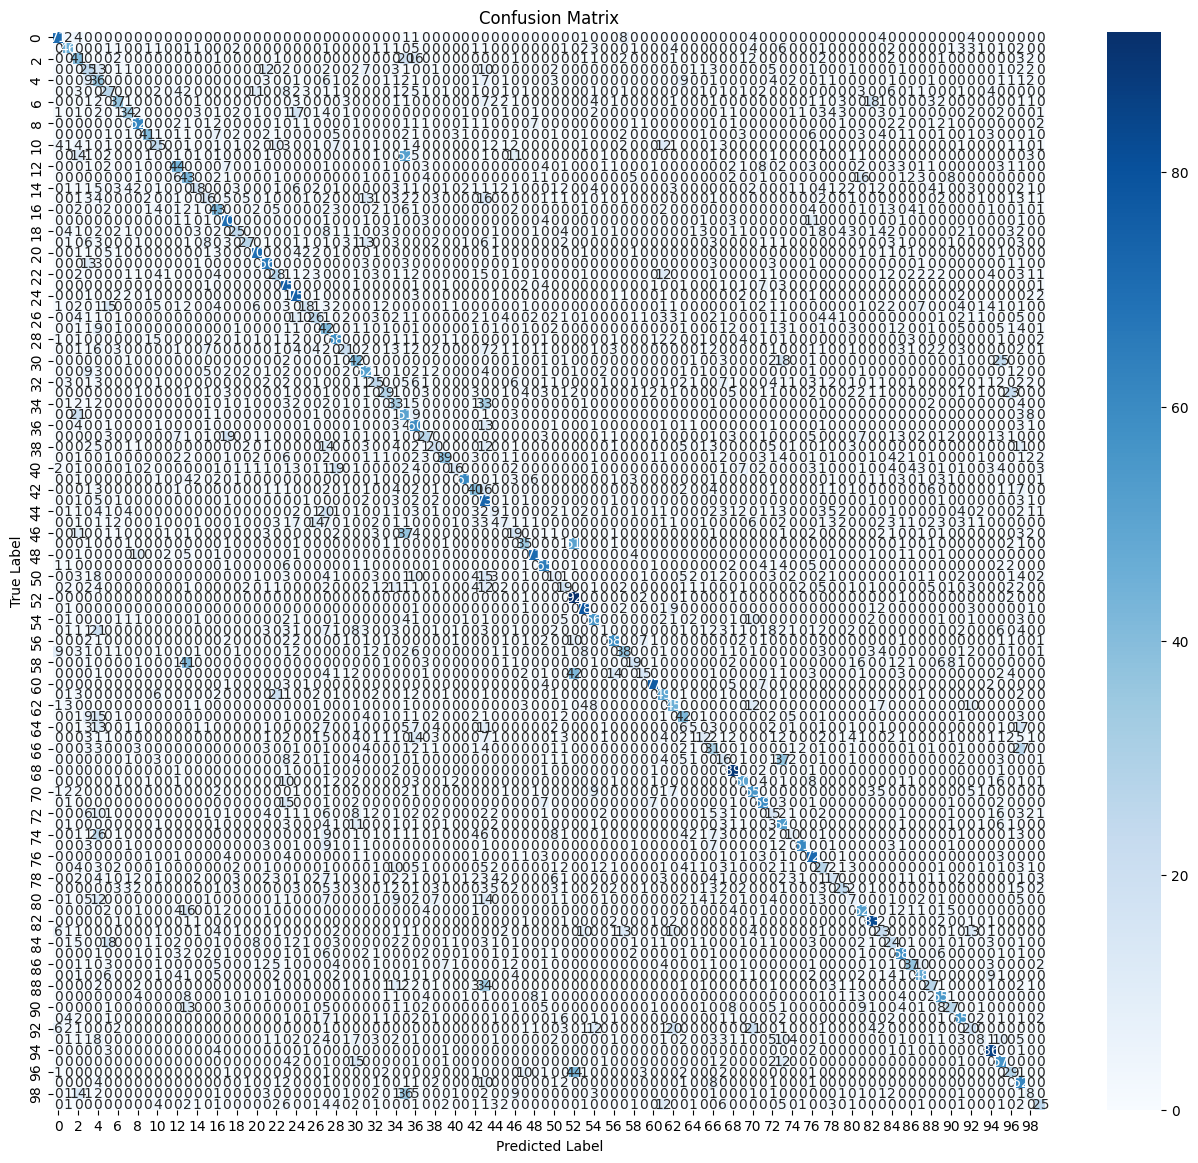

Accuracy of the network on the 10000 test images: 39.72%


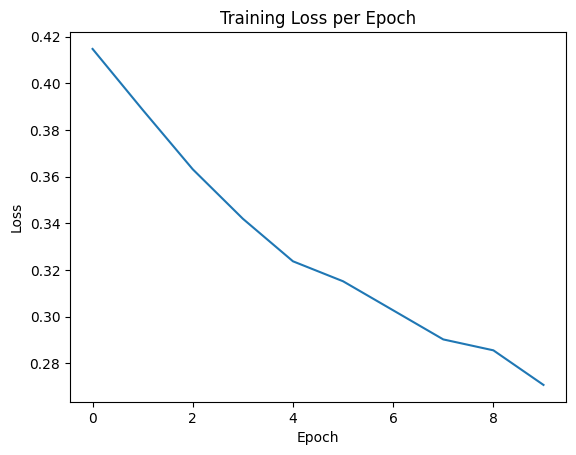

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Загрузка и предобработка данных с аугментацией
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # Нормализация для CIFAR-100
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

# 2. Определение улучшенной модели CNN с Batch Normalization
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(512, 100)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# 3. Инициализация модели, функции потерь и оптимизатора
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EnhancedCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# 4. Функция для обучения модели
def train_model(model, trainloader, criterion, optimizer, scheduler, epochs=10):
    train_loss = []
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Печать каждые 100 batch'ей
                print(f'[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f}')
                running_loss = 0.0

        scheduler.step()
        train_loss.append(running_loss / len(trainloader))

    print('Finished Training')
    return train_loss

# 5. Функция для тестирования модели и построения матрицы ошибок
def test_model_with_confusion_matrix(model, testloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Построение матрицы ошибок
    cm = confusion_matrix(all_labels, all_preds)

    # Визуализация матрицы с помощью seaborn
    plt.figure(figsize=(16, 14))  # Увеличение размеров фигуры
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Подсчет точности
    correct = sum(p == t for p, t in zip(all_preds, all_labels))
    total = len(all_labels)
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f}%')

# 6. Функция для визуализации произвольного изображения
def visualize_prediction(image, model):
    model.eval()
    image = image.unsqueeze(0).to(device)  # Добавляем batch размерность
    output = model(image)
    _, predicted = torch.max(output, 1)
    print(f'Predicted class: {predicted.item()}')

# 7. Обучение модели
train_loss = train_model(model, trainloader, criterion, optimizer, scheduler, epochs=10)

# 8. Тестирование модели и построение матрицы ошибок
test_model_with_confusion_matrix(model, testloader)

# 9. Построение графика ошибки
plt.plot(train_loss)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
